# Статистический анализ тарифов оператора сотовой связи
Сделать предварительный анализ тарифов на небольшой выборке клиентов. Есть данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

# Предобработка

In [622]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import math as mt
from scipy import stats as st

# Options for pandas
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
pd.options.display.max_columns = None
pd.options.display.max_colwidth = 300

calls = pd.read_csv('calls.csv') 
messages = pd.read_csv('messages.csv')
internet = pd.read_csv('internet.csv')
users = pd.read_csv('users.csv')
tariffs = pd.read_csv('tariffs.csv') 



In [623]:
[display(i.info(), i.head()) for i in [calls, messages, internet, users, tariffs]];

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


None

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


None

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


None

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


None

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


None

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


В таблицах `calls`, `messages`, `internet`, `users` нужно привести столбцы с датой к соответствующему типу

In [624]:
calls['call_date'] = pd.to_datetime(calls['call_date'])
messages['message_date'] = pd.to_datetime(messages['message_date'])
internet['session_date'] = pd.to_datetime(internet['session_date'])
users['churn_date'] = pd.to_datetime(users['churn_date'])
users['reg_date'] = pd.to_datetime(users['reg_date'])


In [625]:
internet = internet.drop('Unnamed: 0', axis = 1)

Для удобства и последующего соединения таблиц можно переименовать столбцы `id` в соответствии с категорией, к которой они относятся

In [626]:
calls = calls.rename(columns = {'id': 'call_id'})
messages = messages.rename(columns = {'id': 'message_id'})
internet = internet.rename(columns = {'id': 'internet_id'})

Каких-либо явных пропусков в данных нет (кроме `churn_date` и нулей в `calls`, которыми обозначены пропущенные звонки). Стоит проверить, что дата прекращения пользования тарифом стоит после даты регистрации

In [627]:
users[users['churn_date'] <= users['reg_date']]

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff


Все в порядке, осталось проверить на дубликаты

In [628]:
for i in [calls, messages, internet, users]:
    i.duplicated().sum()

0

0

0

0

Явных дубликатов нет

# Расчет метрик для каждого пользователя

Стоит добавить столбец с месяцем для последующей группировки

In [629]:
calls['call_month'] = calls['call_date'].dt.to_period('M').dt.to_timestamp()
messages['message_month'] = messages['message_date'].dt.to_period('M').dt.to_timestamp()
internet['session_month'] = internet['session_date'].dt.to_period('M').dt.to_timestamp()

## Количество сделанных звонков и израсходованных минут разговора по месяцам

In [630]:
calls_per_month = calls.sort_values(by = ['user_id', 'call_month'])\
    .groupby(['user_id', 'call_month'])\
    .agg({'call_id': 'count', 'duration': 'sum'})\
    .rename(columns={'call_id': 'calls_count', 'duration': 'month_duration'})

calls_per_month.head(10)

calls_count  month_duration
user_id call_month                             
1000    2018-05-01           22          150.06
        2018-06-01           43          158.90
        2018-07-01           47          318.80
        2018-08-01           52          389.87
        2018-09-01           58          440.14
        2018-10-01           57          328.45
        2018-11-01           43          319.04
        2018-12-01           46          312.98
1001    2018-11-01           59          408.12
        2018-12-01           63          391.34

## Количество отправленных сообщений по месяцам

In [631]:
messages_per_month = messages.sort_values(by = ['user_id', 'message_month'])\
    .groupby(['user_id', 'message_month'])\
    .agg({'message_id': 'count'})\
    .rename(columns={'message_id': 'messages_count'})

messages_per_month.head(10)

messages_count
user_id message_month                
1000    2018-05-01                 22
        2018-06-01                 60
        2018-07-01                 75
        2018-08-01                 81
        2018-09-01                 57
        2018-10-01                 73
        2018-11-01                 58
        2018-12-01                 70
1002    2018-06-01                  4
        2018-07-01                 11

## Объем израсходованного интернет-трафика по месяцам

In [632]:
internet_per_month = internet.sort_values(by = ['user_id', 'session_month'])\
    .groupby(['user_id', 'session_month'])\
    .agg({'mb_used': 'sum'})\
    .rename(columns={'mb_used': 'mb_used_total'})

internet_per_month.head(10)

mb_used_total
user_id session_month               
1000    2018-05-01           2253.49
        2018-06-01          23233.77
        2018-07-01          14003.64
        2018-08-01          14055.93
        2018-09-01          14568.91
        2018-10-01          14702.49
        2018-11-01          14756.47
        2018-12-01           9817.61
1001    2018-11-01          18429.34
        2018-12-01          14036.66

## Помесячная выручка с каждого пользователя

In [633]:
total_metrics = calls_per_month.merge(messages_per_month,
                      left_index=True, 
                      right_on=['user_id', 'message_month'],
                      how = 'outer'
                     ).sort_index()\
                     .merge(internet_per_month,
                      left_index=True, 
                      right_on=['user_id', 'session_month'],
                      how = 'outer'
                     ).sort_index().reset_index()

total_metrics.head(10)

,user_id,session_month,calls_count,month_duration,messages_count,mb_used_total
0,1000,2018-05-01,22.0,150.06,22.0,2253.49
1,1000,2018-06-01,43.0,158.90,60.0,23233.77
2,1000,2018-07-01,47.0,318.80,75.0,14003.64
3,1000,2018-08-01,52.0,389.87,81.0,14055.93
4,1000,2018-09-01,58.0,440.14,57.0,14568.91
5,1000,2018-10-01,57.0,328.45,73.0,14702.49
6,1000,2018-11-01,43.0,319.04,58.0,14756.47
7,1000,2018-12-01,46.0,312.98,70.0,9817.61
8,1001,2018-11-01,59.0,408.12,NaN,18429.34
9,1001,2018-12-01,63.0,391.34,NaN,14036.66


Все данные сгруппированы по пользователю и месяцу. Теперь нужно объединить с данными тарифного плана для расчета помесячной выручки

In [634]:
total_revenue = total_metrics.merge(users[['user_id', 'tariff']], on = 'user_id', how='left')\
             .merge(tariffs, left_on='tariff', right_on='tariff_name', how='left')\
             .drop('tariff_name', axis = 1)\
             .rename(columns={'session_month': 'month', 'month_duration': 'calls_duration'})

In [635]:
# функция для подсчета помесячной выручки с каждого пользователя
def revenue(df):
# все значения в впределах тарифа
    revenue = df['rub_monthly_fee']
    if df['calls_duration'] <= df['minutes_included'] \
        and df['messages_count'] <= df['messages_included'] \
        and df['mb_used_total'] <= df['mb_per_month_included']:
            return revenue 
# количество минут в звонках за месяц больше, чем в тарифе
    if df['calls_duration'] > df['minutes_included']:
            revenue += np.ceil(df['calls_duration'] - df['minutes_included'])*df['rub_per_minute']
# количество сообщений за месяц больше, чем в тарифе
    if df['messages_count'] > df['messages_included']:
            revenue += np.ceil(df['messages_count'] - df['messages_included'])*df['rub_per_message']
# количество Гб в интернет-трафике за месяц больше, чем в тарифе            
    if df['mb_used_total'] > df['mb_per_month_included']:
            revenue += (np.ceil(df['mb_used_total'] / 1024) - (df['mb_per_month_included'] / 1024))\
                * df['rub_per_gb']
        
    return revenue 
        
    
    
total_revenue['revenue'] = total_revenue.apply(revenue, axis=1)
total_revenue.head(10)

,user_id,month,calls_count,calls_duration,messages_count,mb_used_total,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,revenue
0,1000,2018-05-01,22.0,150.06,22.0,2253.49,ultra,1000,30720,3000,1950,150,1,1,1950.0
1,1000,2018-06-01,43.0,158.90,60.0,23233.77,ultra,1000,30720,3000,1950,150,1,1,1950.0
2,1000,2018-07-01,47.0,318.80,75.0,14003.64,ultra,1000,30720,3000,1950,150,1,1,1950.0
3,1000,2018-08-01,52.0,389.87,81.0,14055.93,ultra,1000,30720,3000,1950,150,1,1,1950.0
4,1000,2018-09-01,58.0,440.14,57.0,14568.91,ultra,1000,30720,3000,1950,150,1,1,1950.0
5,1000,2018-10-01,57.0,328.45,73.0,14702.49,ultra,1000,30720,3000,1950,150,1,1,1950.0
6,1000,2018-11-01,43.0,319.04,58.0,14756.47,ultra,1000,30720,3000,1950,150,1,1,1950.0
7,1000,2018-12-01,46.0,312.98,70.0,9817.61,ultra,1000,30720,3000,1950,150,1,1,1950.0
8,1001,2018-11-01,59.0,408.12,NaN,18429.34,smart,50,15360,500,550,200,3,3,1150.0
9,1001,2018-12-01,63.0,391.34,NaN,14036.66,smart,50,15360,500,550,200,3,3,550.0


# Анализ данных

Расчет среднего количества, дисперсии и стандартного отклонения выборки для минут разговора, количества сообщений, объёма интернет-трафика и выручки

In [636]:
tariff_distr = total_revenue.groupby(['tariff'])\
        .agg({'calls_duration': ['mean', 'var', 'std'], 
              'messages_count': ['mean', 'var', 'std'],
              'mb_used_total' : ['mean', 'var', 'std'],
              'revenue'       : ['mean', 'var', 'std']})
tariff_distr

calls_duration                           messages_count               \
                 mean           var         std           mean          var   
tariff                                                                        
smart      395.491606  32052.625911  179.032472      38.716441   717.594201   
ultra      514.839327  84002.601260  289.832022      61.161006  2109.659183   

                  mb_used_total                                 revenue  \
              std          mean           var          std         mean   
tariff                                                                    
smart   26.787949  16215.661849  3.435995e+07  5861.736234  1257.588605   
ultra   45.931026  19668.485262  9.886425e+07  9943.050284  2070.152284   

                                   
                  var         std  
tariff                             
smart   641465.797016  800.915599  
ultra   141516.745079  376.187114

В среднем пользователям тарифа `Smart` в месяц нужно:
- на 120 минут меньше, чем пользователям тарифа `Ultra`
- на 12 сообщений меньше, чем пользователям тарифа `Ultra`
- на 3500 Мб интернета меньше, чем пользователям тарифа `Ultra`


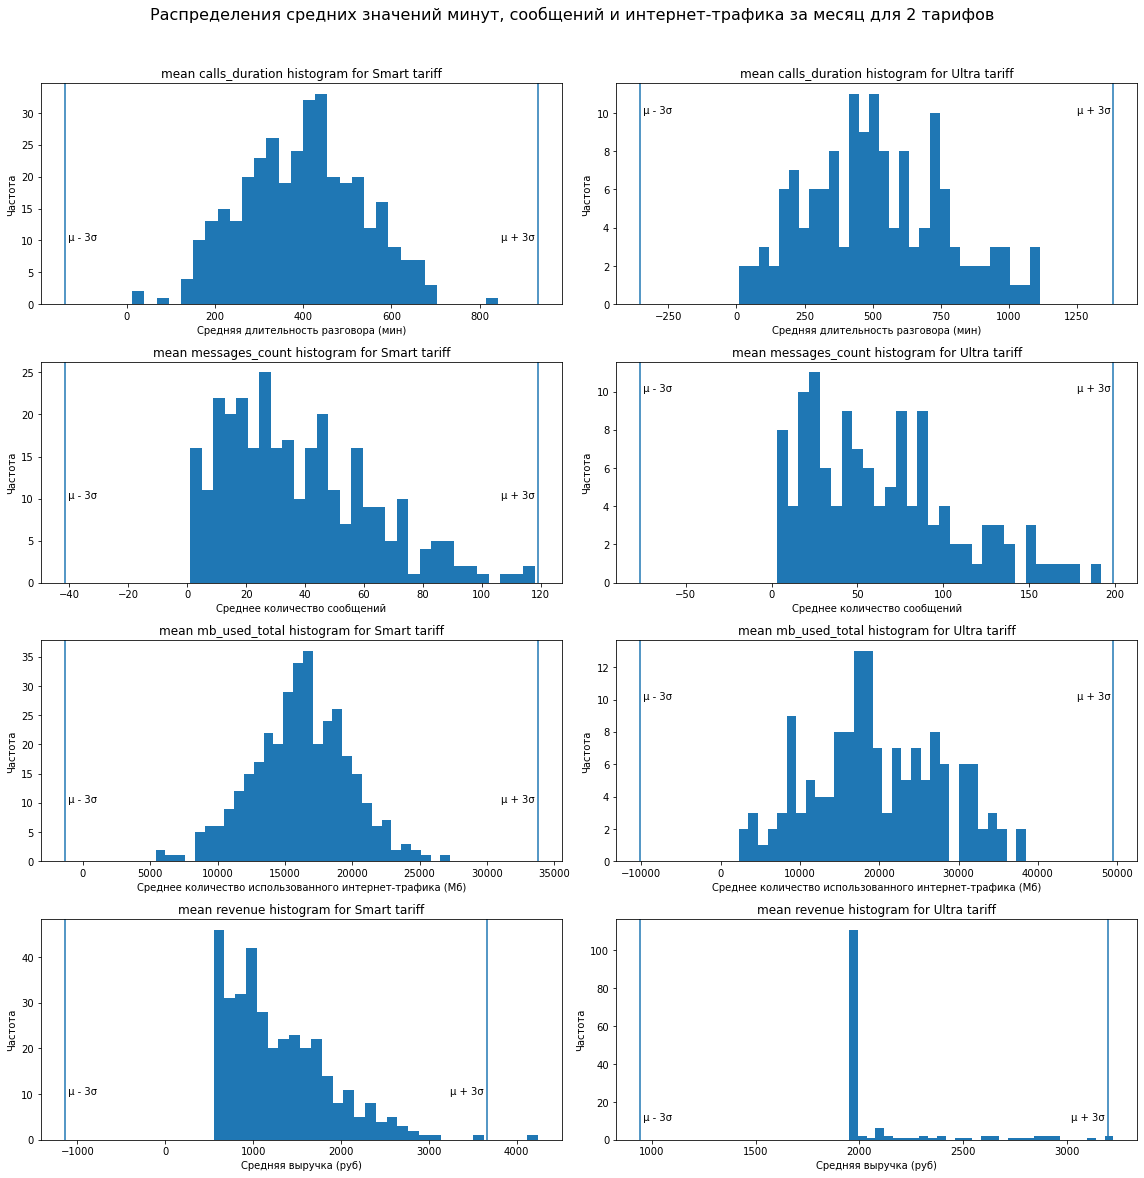

In [637]:
fig, ax = plt.subplots(4, 2, figsize = (16, 16))
fig.suptitle('Распределения средних значений минут, сообщений и интернет-трафика за месяц для 2 тарифов', fontsize = 16, y = 1.02)

for k, i in enumerate(['calls_duration', 'messages_count', 'mb_used_total', 'revenue']): 
    for j in ['smart', 'ultra']:
        if j == 'smart':
            ax[k][0].set_title(f'mean {i} histogram for {j.capitalize()} tariff')
            ax[k][0].axvline(tariff_distr[i]['mean'][0] - 3*tariff_distr[i]['std'][0])
            ax[k][0].text(x = tariff_distr[i]['mean'][0] - 3*tariff_distr[i]['std'][0], y = 10, s = ' μ - 3σ')
            
            ax[k][0].axvline(tariff_distr[i]['mean'][0] + 3*tariff_distr[i]['std'][0])
            ax[k][0].text(x = tariff_distr[i]['mean'][0] + 3*tariff_distr[i]['std'][0],
                          y = 10, s = 'μ + 3σ ', ha = 'right')
       
            ax[k][0].hist(total_revenue.query('tariff == @j').groupby('user_id').mean()[i], bins = 30)
        
        
            if k == 0:
                ax[k][0].set_xlabel('Средняя длительность разговора (мин)')
                ax[k][0].set_ylabel('Частота')
            if k == 1:
                ax[k][0].set_xlabel('Среднее количество сообщений')
                ax[k][0].set_ylabel('Частота')
            if k == 2:
                ax[k][0].set_xlabel('Среднее количество использованного интернет-трафика (Мб)')
                ax[k][0].set_ylabel('Частота')
            if k == 3:
                ax[k][0].set_xlabel('Средняя выручка (руб)')
                ax[k][0].set_ylabel('Частота')
        
        
        if j == 'ultra':
            ax[k][1].set_title(f'mean {i} histogram for {j.capitalize()} tariff')
            ax[k][1].axvline(tariff_distr[i]['mean'][1] - 3*tariff_distr[i]['std'][1])
            ax[k][1].text(x = tariff_distr[i]['mean'][1] - 3*tariff_distr[i]['std'][1], y = 10, s = ' μ - 3σ')

            ax[k][1].axvline(tariff_distr[i]['mean'][1] + 3*tariff_distr[i]['std'][1])
            ax[k][1].text(x = tariff_distr[i]['mean'][1] + 3*tariff_distr[i]['std'][1],
                          y = 10, s = 'μ + 3σ ', ha = 'right')

            ax[k][1].hist(total_revenue.query('tariff == @j').groupby('user_id').mean()[i], bins = 30)
            
            if k == 0:
                ax[k][1].set_xlabel('Средняя длительность разговора (мин)')
                ax[k][1].set_ylabel('Частота')
            if k == 1:
                ax[k][1].set_xlabel('Среднее количество сообщений')
                ax[k][1].set_ylabel('Частота')
            if k == 2:
                ax[k][1].set_xlabel('Среднее количество использованного интернет-трафика (Мб)')
                ax[k][1].set_ylabel('Частота')
            if k == 3:
                ax[k][1].set_xlabel('Средняя выручка (руб)')
                ax[k][1].set_ylabel('Частота')
            
            
            
    
plt.tight_layout()
plt.show();


- Средняя длительность звонка распределена нормально у обоих тарифов
- Среднее количество сообщений имеют положительно скошенное распределение у обоих тарифов
- Среднее количество использованного интернет-трафика также имеет нормальное распределение у `Smart` тарифа, а у `Ultra` много 'провалов' на графике 
- Для всех графиков соблюдается правило 3-х сигм

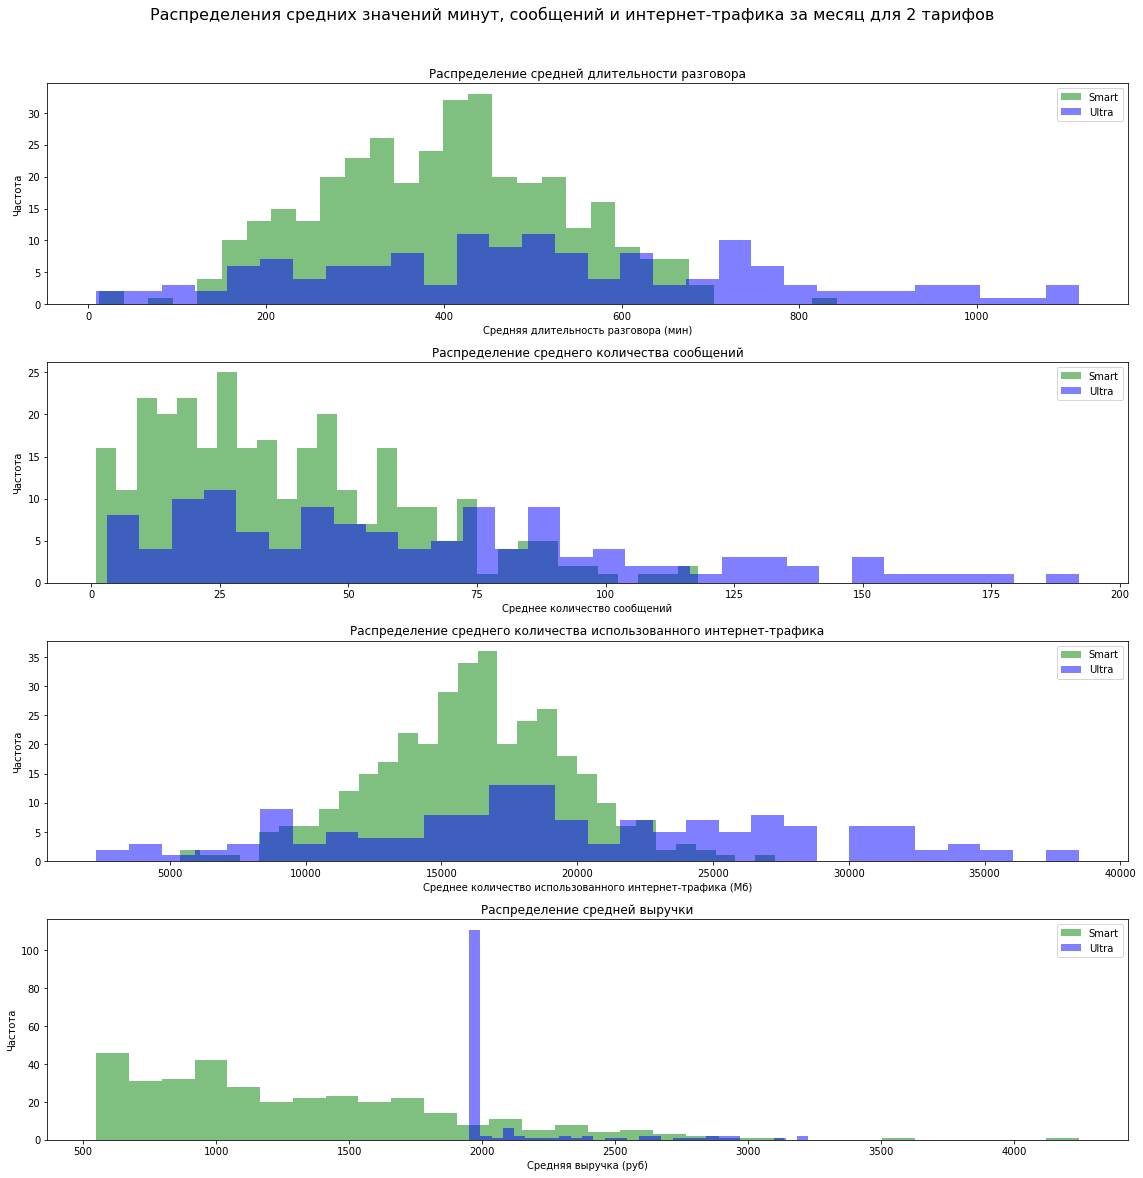

In [638]:
fig, ax = plt.subplots(4, 1, figsize = (16, 16))
fig.suptitle('Распределения средних значений минут, сообщений и интернет-трафика за месяц для 2 тарифов', fontsize = 16, y = 1.02)

for k, i in enumerate(['calls_duration', 'messages_count', 'mb_used_total', 'revenue']):
    if k == 0:
        ax[k].set_title('Распределение средней длительности разговора')
        ax[k].hist(total_revenue.query('tariff == "smart"').groupby('user_id').mean()[i], color= 'g', bins = 30, alpha = 0.5, label = 'Smart')
        ax[k].hist(total_revenue.query('tariff == "ultra"').groupby('user_id').mean()[i], color= 'b', bins = 30, alpha = 0.5, label = 'Ultra')
        ax[k].set_xlabel('Средняя длительность разговора (мин)')
        ax[k].set_ylabel('Частота')
        ax[k].legend()
    
    if k == 1:
        ax[k].set_title('Распределение среднего количества сообщений')
        ax[k].hist(total_revenue.query('tariff == "smart"').groupby('user_id').mean()[i], color= 'g', bins = 30, alpha = 0.5, label = 'Smart')
        ax[k].hist(total_revenue.query('tariff == "ultra"').groupby('user_id').mean()[i], color= 'b', bins = 30, alpha = 0.5, label = 'Ultra')
        ax[k].set_xlabel('Среднее количество сообщений')
        ax[k].set_ylabel('Частота')
        ax[k].legend()
        
    if k == 2:
        ax[k].set_title('Распределение среднего количества использованного интернет-трафика')
        ax[k].hist(total_revenue.query('tariff == "smart"').groupby('user_id').mean()[i], color= 'g', bins = 30, alpha = 0.5, label = 'Smart')
        ax[k].hist(total_revenue.query('tariff == "ultra"').groupby('user_id').mean()[i], color= 'b', bins = 30, alpha = 0.5, label = 'Ultra')
        ax[k].set_xlabel('Среднее количество использованного интернет-трафика (Мб)')
        ax[k].set_ylabel('Частота')
        ax[k].legend()
        
    if k == 3:
        ax[k].set_title('Распределение средней выручки')
        ax[k].hist(total_revenue.query('tariff == "smart"').groupby('user_id').mean()[i], color= 'g', bins = 30, alpha = 0.5, label = 'Smart')
        ax[k].hist(total_revenue.query('tariff == "ultra"').groupby('user_id').mean()[i], color= 'b', bins = 30, alpha = 0.5, label = 'Ultra')
        ax[k].set_xlabel('Средняя выручка (руб)')
        ax[k].set_ylabel('Частота')
        ax[k].legend()

plt.tight_layout()
plt.show();

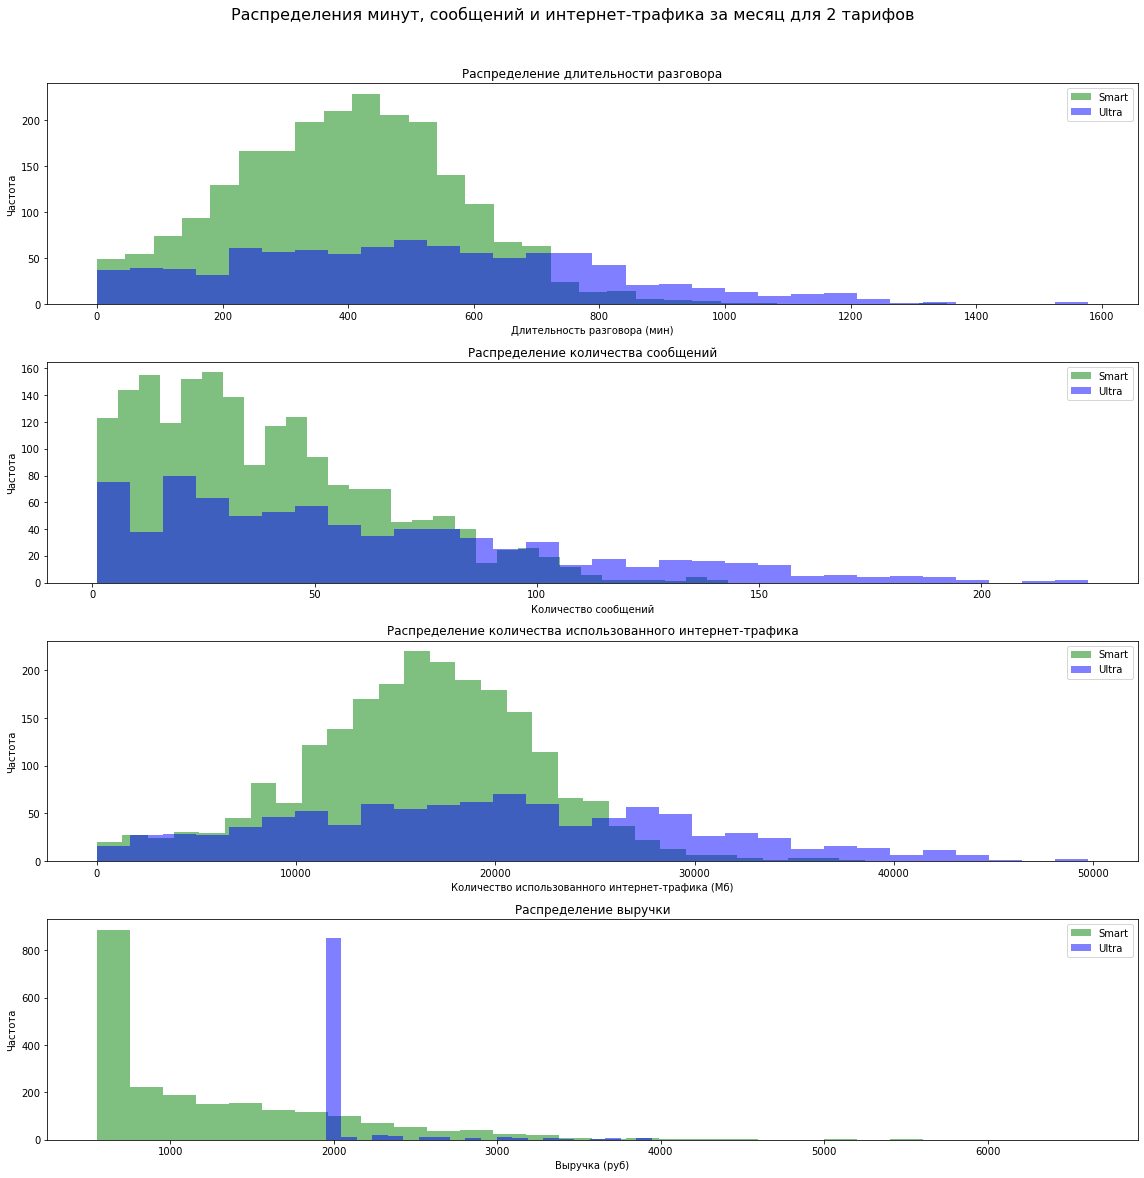

In [639]:
fig, ax = plt.subplots(4, 1, figsize = (16, 16))
fig.suptitle('Распределения минут, сообщений и интернет-трафика за месяц для 2 тарифов', fontsize = 16, y = 1.02)

for k, i in enumerate(['calls_duration', 'messages_count', 'mb_used_total', 'revenue']):
    if k == 0:
        ax[k].set_title('Распределение длительности разговора')
        ax[k].hist(total_revenue.query('tariff == "smart"')[i], color= 'g', bins = 30, alpha = 0.5, label = 'Smart')
        ax[k].hist(total_revenue.query('tariff == "ultra"')[i], color= 'b', bins = 30, alpha = 0.5, label = 'Ultra')
        ax[k].set_xlabel('Длительность разговора (мин)')
        ax[k].set_ylabel('Частота')
        ax[k].legend()
    
    if k == 1:
        ax[k].set_title('Распределение количества сообщений')
        ax[k].hist(total_revenue.query('tariff == "smart"')[i], color= 'g', bins = 30, alpha = 0.5, label = 'Smart')
        ax[k].hist(total_revenue.query('tariff == "ultra"')[i], color= 'b', bins = 30, alpha = 0.5, label = 'Ultra')
        ax[k].set_xlabel('Количество сообщений')
        ax[k].set_ylabel('Частота')
        ax[k].legend()
        
    if k == 2:
        ax[k].set_title('Распределение количества использованного интернет-трафика')
        ax[k].hist(total_revenue.query('tariff == "smart"')[i], color= 'g', bins = 30, alpha = 0.5, label = 'Smart')
        ax[k].hist(total_revenue.query('tariff == "ultra"')[i], color= 'b', bins = 30, alpha = 0.5, label = 'Ultra')
        ax[k].set_xlabel('Количество использованного интернет-трафика (Мб)')
        ax[k].set_ylabel('Частота')
        ax[k].legend()
        
    if k == 3:
        ax[k].set_title('Распределение выручки')
        ax[k].hist(total_revenue.query('tariff == "smart"')[i], color= 'g', bins = 30, alpha = 0.5, label = 'Smart')
        ax[k].hist(total_revenue.query('tariff == "ultra"')[i], color= 'b', bins = 30, alpha = 0.5, label = 'Ultra')
        ax[k].set_xlabel('Выручка (руб)')
        ax[k].set_ylabel('Частота')
        ax[k].legend()

plt.tight_layout()
plt.show();

- При нанесении распределений двух тарифов на один график можно увидеть, что они имеют схожий вид как для средних значений, так и для всех вообще 
- Также для тарифа `Smart` больше характерно нормальное распределение, а для `Ultra` - больше равномерное распределение
- На обоих графиках с выручкой абсолютное большинство значений для тарифа `Ultra` находятся в районе 2000 руб. (на уровне цены тарифа), а для тарифа `Smart` много значений экспоненциально распределены дальше от цены тарифа (550 руб.)

# Проверка гипотез


## Гипотеза  1

Так как 0-я гипотеза - это гипотеза об отсутствии различий, а альтернативная - это гипотеза о значимости различий, то их можно сформулировать так:
- H0: средняя выручка пользователей тарифа «Ультра» и тарифа «Смарт» не отличаются
- H1: средняя выручка пользователей тарифа «Ультра» и тарифа «Смарт» отличаются


При условии, что 0-я гипотеза верна, необходимо задать вероятность отклонить 0-ю гипотезу, пусть это будет 0.05 для обеих гипотез

In [640]:
alpha = 0.05 # критический уровень статистической значимости

Стоит сгруппировать общую выручку по каждому пользователю за все время и добавить к таблице `total_revenue`

In [641]:
total_revenue = total_revenue.merge(total_revenue.groupby('user_id')['revenue']\
                    .sum().reset_index().rename(columns = {'revenue': 'total_revenue'}),
                    on = 'user_id', how ='left')

total_revenue.head()

,user_id,month,calls_count,calls_duration,messages_count,mb_used_total,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,revenue,total_revenue
0,1000,2018-05-01,22.0,150.06,22.0,2253.49,ultra,1000,30720,3000,1950,150,1,1,1950.0,15600.0
1,1000,2018-06-01,43.0,158.90,60.0,23233.77,ultra,1000,30720,3000,1950,150,1,1,1950.0,15600.0
2,1000,2018-07-01,47.0,318.80,75.0,14003.64,ultra,1000,30720,3000,1950,150,1,1,1950.0,15600.0
3,1000,2018-08-01,52.0,389.87,81.0,14055.93,ultra,1000,30720,3000,1950,150,1,1,1950.0,15600.0
4,1000,2018-09-01,58.0,440.14,57.0,14568.91,ultra,1000,30720,3000,1950,150,1,1,1950.0,15600.0


In [642]:
smart_mean = total_revenue.groupby('tariff')['total_revenue'].mean()[0] # Средняя выручка для 'smart'
ultra_mean = total_revenue.groupby('tariff')['total_revenue'].mean()[1] # Средняя выручка для 'ultra'

smart_mean
ultra_mean

smart_arr = total_revenue.query('tariff == "smart"')\
    .groupby('user_id')['total_revenue'].mean() # Выборка c выручкой пользователей для 'smart'
ultra_arr = total_revenue.query('tariff == "ultra"')\
    .groupby('user_id')['total_revenue'].mean() # Выборка с выручкой пользователей для 'ultra'


smart_arr
ultra_arr

10064.942126514132

16992.48730964467

user_id
1001     1700.0
1002     7250.0
1005     9045.0
1006    10250.0
1007     7867.0
         ...   
1494     4950.0
1496    27700.0
1497     2698.0
1498     6636.0
1499     3706.0
Name: total_revenue, Length: 350, dtype: float64

user_id
1000    15600.0
1003     9750.0
1004    15600.0
1013     3900.0
1016     3900.0
         ...   
1476    17550.0
1485     1950.0
1491    17550.0
1493     5700.0
1495    11550.0
Name: total_revenue, Length: 148, dtype: float64

In [643]:
np.var(smart_arr)
np.var(ultra_arr)

27818016.84102043

46841158.235938646

Так как дисперсии отличаются, то стоит поставить False в equal_var

In [644]:
results = st.ttest_ind(smart_arr, ultra_arr, equal_var = False)

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение:  3.883219773765792e-17
Отвергаем нулевую гипотезу


В результате проверки гипотезы о равенстве средней выручки пользователей тарифов «Ультра» и «Смарт» ее пришлось отвергнуть

## Гипотеза  2

Так как 0-я гипотеза - это гипотеза об отсутствии различий, а альтернативная - это гипотеза о значимости различий, то их можно сформулировать так:
- H0: средняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов
- H1: средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов


In [645]:
city_revenue = total_revenue.groupby('user_id')['total_revenue'].mean()\
    .reset_index().merge(users[['user_id', 'city']], on = 'user_id', how = 'left')

city_revenue.head()

,user_id,total_revenue,city
0,1000,15600.0,Краснодар
1,1001,1700.0,Москва
2,1002,7250.0,Стерлитамак
3,1003,9750.0,Москва
4,1004,15600.0,Новокузнецк


In [646]:
msc_arr = city_revenue.query('city == "Москва"')['total_revenue']
not_msc_arr = city_revenue.query('city != "Москва"')['total_revenue']

msc_arr
not_msc_arr

msc_mean = msc_arr.mean()
not_msc_mean = not_msc_arr.mean()

msc_mean
not_msc_mean

1       1700.0
3       9750.0
7       7867.0
31      1607.0
33     11484.0
        ...   
451    23400.0
459     3900.0
474    17550.0
479    12650.0
488     9786.0
Name: total_revenue, Length: 99, dtype: float64

0      15600.0
2       7250.0
4      15600.0
5       9045.0
6      10250.0
        ...   
493    11550.0
494    27700.0
495     2698.0
496     6636.0
497     3706.0
Name: total_revenue, Length: 399, dtype: float64

9423.212121212122

9797.912280701754

In [647]:
np.var(msc_arr)
np.var(not_msc_arr)

43580603.64187327

39610448.80684166

Дисперсии отличаются

In [648]:
results = st.ttest_ind(msc_arr, not_msc_arr, equal_var = False)

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение:  0.6122814625387962
Не получилось отвергнуть нулевую гипотезу


Так как p-value получилось больше критического уровеня статистической значимости, то гипотезу о том, что средняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов не стоит отвергать

## Вывод

- В среднем пользователям тарифа Smart в месяц нужно меньше минут для звонков, сообщений и интернет-трафика, чем пользователям тарифа Ultra
- Пользователи тарифа Smart в среднем укладываются по минутам и сообщениям в основной тариф, а по интернету пользуются дополнительной абонентской платой
- Пользователи тарифа Ultra в среднем полностью укладываются по минутам, сообщениям и интернет-трафику в основной тариф, причем у них остается большой объем неиспользованных данных
- Гипотезу о том, что средняя выручка пользователей тарифа «Ультра» и тарифа «Смарт» не отличаются пришлось отвергнуть 
- Гипотезу о том, что средняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов не удалось отвергнуть 

Сравнивая общую среднюю выручку по тарифам, по пользователям за все время и тарифам, выручка будет больше у тарифа «Ультра», также в этом тарифе почти все пользователи платят только за сам тариф, и зачастую им не удается потратить все минуты, сообщения и интернет-трафик, поэтому «Ультра» можно считать более выгодным, чем «Смарт»